# Notebook for Sequence to Sequence with Attention(Bahdanau,Luong) 

## Load translation examples from the file and use torchtext build dataset
See dataset.py
- we follew the procedure of torchtext
    - we define `Field` which decide our preprocess of text
    - we create a `torchtext.legacy.data.Dataset` instance in the our way
    - than we can use `BucketIterator` method to build Dataloader(Iterator). `BucketIterator` will minimizes amount of padding needed while producing freshly shuffled, this could improve our model's performance. see [source](https://github.com/pytorch/text/blob/release/0.10/torchtext/legacy/data/iterator.py)
- To improve
    - Our custom `Dataset` classes and `torchtext.legacy.data.Dataset` classes both refered to Dataset, this can cause confusion
    
## Load & Vaildate model

We loaded models for single-sentence translation tests using the decoding methods of greedy and beam search respectively

In [1]:
from dataset import Dataset

reverse_src = True
device = "cuda"
dataset = Dataset(reverse_src, device)

## Build vocabulary
After create a `torchtext.legacy.data.Dataset` instance, we can use method of `Field` to build vocabulary

In [2]:
word_minq = 1
dataset.build_vocab(word_minq,word_minq)

src_vocab_size = len(dataset.srcField.vocab)
trg_vocab_size = len(dataset.trgField.vocab)
src_pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
trg_pad_idx = dataset.trgField.vocab.__getitem__(dataset.special_tokens['pad'])

### View data in each batch

In [3]:
batch_size = 128
train_iterator, val_iterator, test_iter = dataset.build_DataLoad(batch_size)

for batch in train_iterator:
    src, src_len = batch.src
    trg, trg_len = batch.trg
    print(src,src_len)
    print([dataset.srcField.vocab.itos[i] for i in src[0]])
    print(trg,trg_len)
    print([dataset.trgField.vocab.itos[i] for i in trg[0]])
    break

tensor([[   2,    5, 1497,  ...,  145,   16,    3],
        [   2,    5, 3545,  ..., 1387,    4,    3],
        [   2,    5,   85,  ...,   35,    4,    3],
        ...,
        [   2,    5,  138,  ...,    9,    4,    3],
        [   2,    5,  330,  ...,  747,  113,    3],
        [   2,    5, 3966,  ...,   24,    4,    3]], device='cuda:0') tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16], device='cuda:0')
['<bos>', '.', 'houses', 'of', 'front', 'in', 'sidewalk', 'the'

## Train a Seq2Seq with Luong Attention model
- set hyperparameter in '/Luong/hyperparameter.py'

In [4]:
from Luong.models import Seq2Seq

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx).to(device)

print(model.parameters)
print(model.decoder.attention.method)

/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<bound method Module.parameters of Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9796, 256, padding_idx=1)
    (rnn): GRU(256, 512, batch_first=True, dropout=0.15)
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18668, 256, padding_idx=1)
    (dropout): Dropout(p=0.15, inplace=False)
    (rnn): GRU(768, 512, batch_first=True, dropout=0.15)
    (attention): Luong_Attention(
      (W): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (out_fc): Linear(in_features=512, out_features=18668, bias=True)
  )
)>
MLP


In [5]:
from Luong.trainer import train
import torch

clip = 5
lr = 1e-2
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, clip, dataset, 
      num_epochs=10, mini_batch_size=128, accum_iter=1,
      print_every=50)

model.save("Luong02_E10.pt")

batch_size: 128
-----------------------------------------------------------------
Epoch 1
-----------------------------------------------------------------
[ 50/227 ] Loss: 6.004956... Val Loss: 5.688063... Val BLEU: 0.000000...
[ 100/227 ] Loss: 5.344352... Val Loss: 5.528790... Val BLEU: 1.920246...
[ 150/227 ] Loss: 5.321623... Val Loss: 5.373023... Val BLEU: 2.103059...
[ 200/227 ] Loss: 4.381223... Val Loss: 5.174333... Val BLEU: 3.312080...
[ 227/227 ] Loss: 5.392112... Val Loss: 5.468957... Val BLEU: 3.013344...
Total Epoche:  |    Time: 0m 32s
 Epoch Loss: 5.341850... Train BLEU: 2.531414...
-----------------------------------------------------------------
Epoch 2
-----------------------------------------------------------------
[ 50/227 ] Loss: 5.520894... Val Loss: 4.902682... Val BLEU: 6.796175...
[ 100/227 ] Loss: 3.927659... Val Loss: 4.668367... Val BLEU: 9.287969...
[ 150/227 ] Loss: 4.366240... Val Loss: 4.497064... Val BLEU: 11.223089...
[ 200/227 ] Loss: 3.898019... V

### Load the model

In [6]:
from Luong.models import Seq2Seq

device = "cuda"

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)
model.load("Luong02_E10.pt",device)

print(model.parameters)
print(model.decoder.attention.method)

<bound method Module.parameters of Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9796, 256, padding_idx=1)
    (rnn): GRU(256, 512, batch_first=True, dropout=0.15)
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18668, 256, padding_idx=1)
    (dropout): Dropout(p=0.15, inplace=False)
    (rnn): GRU(768, 512, batch_first=True, dropout=0.15)
    (attention): Luong_Attention(
      (W): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (out_fc): Linear(in_features=512, out_features=18668, bias=True)
  )
)>
MLP


/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Validate Model
### BLEU score and Cost in Test_set

In [7]:
batch_size = 128
train_iterator, val_iterator, test_iter = dataset.build_DataLoad(batch_size)


from Luong.validator import evaluate

pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
bos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['bos'])
eos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['eos'])

test_loss, BLEU_score = evaluate(model, test_iter,
                                 pad_idx, bos_idx, eos_idx,
                                 trgField=dataset.trgField, BLEU=True)

print("Test set cost:",test_loss,"  |  Test set BLEU score:",BLEU_score)

Test set cost: 3.6415696144104004   |  Test set BLEU score: 31.208941690841264


### Single sentence translation and Attention visualization
#### Greedy decode

/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


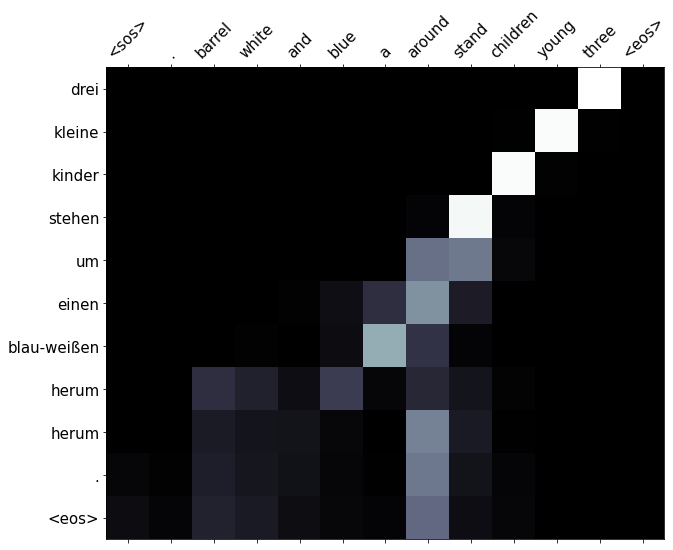

In [8]:
from Luong.validator import single_decode
from Luong.validator import display_attention

# src = "a little girl climbing into a wooden playhouse ."
src = "three young children stand around a blue and white barrel ."

src_sentence, translation, atten_weights = single_decode(model, src, dataset, "greedy", reverse_src=reverse_src)



display_attention(src_sentence, translation, atten_weights)

#### Beam Search decode

In [12]:
from Luong.validator import single_decode

# src = "three young children."
# src = "three woman holding a bowl of food in a kitchen ."
src = "three young children stand around a blue and white barrel ."

src_sentence, translation, atten_weights = single_decode(model, src, dataset, "beam", beam_width=12, reverse_src=reverse_src)
for sentence in translation:
    print(' '.join(sentence))

drei kleine kinder stehen um einen blau-weißen herum . <eos>
drei kleine kinder stehen um einen blau-weißen herum herum . <eos>
drei kleine kinder stehen um einem blau-weißen herum herum . <eos>
drei kleine kinder stehen um einen blau-weißen fass herum . <eos>
drei kleine kinder stehen um einen blau-weißen gabelstapler herum . <eos>
drei kleine kinder stehen um um einen blau-weißen fass herum . <eos>
drei kleine kinder stehen um um einem blau-weißen fass herum . <eos>
drei kleine kinder stehen um um einen blau-weißen herum herum . <eos>
drei kleine kinder stehen um um einem blau-weißen herum herum . <eos>
drei kleine kinder stehen um um ein blau-weißen fass herum . <eos>
drei kleine kinder stehen um einen blau-weißen herum herum herum . <eos>
drei kleine kinder stehen um um eine blau-weißen fass herum . <eos>


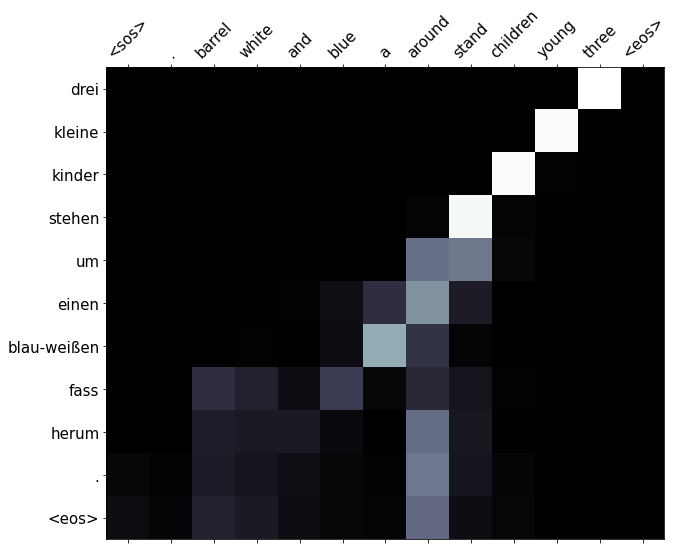

In [14]:
from Luong.validator import display_attention

sentence_num = 3

display_attention(src_sentence, translation[sentence_num], atten_weights[sentence_num])

## Train a Seq2Seq with Bahdanau Attention model
- We build dataset from scratch because we don't need to reverse order of source sentence
- set hyperparameter in '/Bahdanau/hyperparameter.py'

In [1]:
from dataset import Dataset

reverse_src = False
device = "cuda"
dataset = Dataset(reverse_src, device)

In [2]:
word_minq = 1
dataset.build_vocab(word_minq,word_minq)

src_vocab_size = len(dataset.srcField.vocab)
trg_vocab_size = len(dataset.trgField.vocab)
src_pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
trg_pad_idx = dataset.trgField.vocab.__getitem__(dataset.special_tokens['pad'])

In [3]:
from Bahdanau.models import Seq2Seq

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx).to(device)

print(model.parameters)

/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<bound method Module.parameters of Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9796, 256, padding_idx=1)
    (rnn): GRU(256, 512, batch_first=True, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18668, 256, padding_idx=1)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): GRU(1280, 512, batch_first=True, dropout=0.2)
    (attention): Bahdanau_Attention(
      (W): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc_out): Linear(in_features=1792, out_features=18668, bias=True)
  )
)>


In [14]:
from Bahdanau.trainer import train
import torch

clip = 5
lr = 1e-2
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, clip, dataset, 
      num_epochs=15, mini_batch_size=128, accum_iter=1,
      print_every=50)

model.save("Bahdanau_seq2seq_E15.pt")

batch_size: 128
-----------------------------------------------------------------
Epoch 1
-----------------------------------------------------------------
[ 50/227 ] Loss: 5.049674... Val Loss: 5.342378... Val BLEU: 3.209483...
[ 100/227 ] Loss: 4.342801... Val Loss: 4.617905... Val BLEU: 10.366082...
[ 150/227 ] Loss: 3.853774... Val Loss: 4.124403... Val BLEU: 15.601981...
[ 200/227 ] Loss: 3.424032... Val Loss: 3.913564... Val BLEU: 19.344881...
[ 227/227 ] Loss: 2.989331... Val Loss: 3.869242... Val BLEU: 18.763480...
Total Epoche:  |    Time: 0m 55s
 Epoch Loss: 3.501581... Train BLEU: 19.541865...
-----------------------------------------------------------------
Epoch 2
-----------------------------------------------------------------
[ 50/227 ] Loss: 3.801366... Val Loss: 3.729189... Val BLEU: 22.665945...
[ 100/227 ] Loss: 2.627002... Val Loss: 3.601325... Val BLEU: 24.186329...
[ 150/227 ] Loss: 2.387233... Val Loss: 3.628886... Val BLEU: 22.947622...
[ 200/227 ] Loss: 3.2401

### Load the model

In [3]:
from Bahdanau.models import Seq2Seq

device = "cuda"

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)
model.load("Bahdanau_seq2seq_E15.pt",device)

print(model.parameters)

/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<bound method Module.parameters of Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9796, 256, padding_idx=1)
    (rnn): GRU(256, 512, batch_first=True, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18668, 256, padding_idx=1)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): GRU(1280, 512, batch_first=True, dropout=0.2)
    (attention): Bahdanau_Attention(
      (W): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc_out): Linear(in_features=1792, out_features=18668, bias=True)
  )
)>


### Single sentence translation and Attention visualization
#### Greedy decode

In [10]:
from Bahdanau.validator import single_decode

src = "a little girl climbing into a wooden playhouse ."

src_sentence, translation, atten_weights = single_decode(model, src, dataset, "greedy")

In [13]:
print(' '.join(translation))

ein kleines mädchen klettert in ein spielhaus aus holz . <eos>


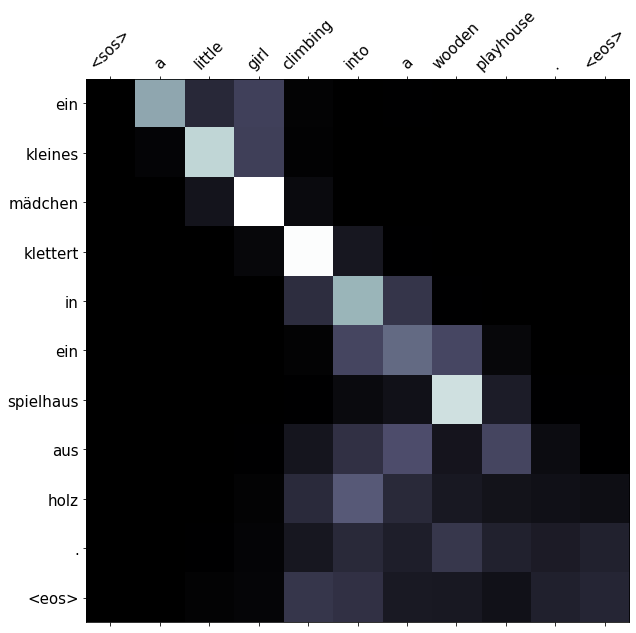

In [14]:
from Bahdanau.validator import display_attention

display_attention(src_sentence, translation, atten_weights)

#### Beam Search decode

In [15]:
from Bahdanau.validator import single_decode

src = "a little girl climbing into a wooden playhouse ."
src_sentence, translation, atten_weights = single_decode(model, src, dataset, "beam", beam_width=12)

In [16]:
for sentence in translation:
    print(' '.join(sentence))

ein kleines mädchen klettert in einen spielhaus . <eos>
ein kleines mädchen klettert in ein spielhaus . <eos>
ein kleines mädchen klettert in ein spielhaus aus <eos>
ein kleines mädchen klettert in eine holzskulptur . <eos>
ein kleines mädchen klettert in ein spielhaus aus . <eos>
ein kleines mädchen klettert in ein spielhaus aus holz <eos>
ein kleines mädchen klettert in einen spielhaus aus . <eos>
ein kleines mädchen klettert ein spielhaus aus holz . <eos>
ein kleines mädchen klettert in ein spielhaus aus holz . <eos>
ein kleines mädchen klettert in einen spielhaus aus holz . <eos>
ein kleines mädchen klettert in eine spielhaus aus holz . <eos>
ein kleines mädchen klettert auf ein spielhaus aus holz . <eos>


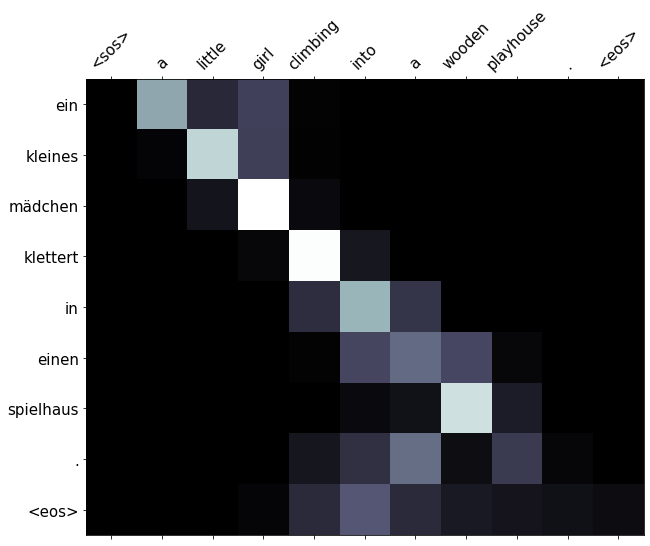

In [17]:
from Bahdanau.validator import display_attention

sentence_num = 0

display_attention(src_sentence, translation[sentence_num], atten_weights[sentence_num])